# Image classification: cats & dogs

In [1]:
# Handle imports up-front
import os
import sys
import glob
import random

# Silence logging messages from TensorFlow, except errors
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# PyPI imports
import numpy as np
import matplotlib.pyplot as plt
import keras.utils as image
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Figure out if we are running on Kaggle or not, if so
# add the location of utils.py to path so we can import
path_list=os.getcwd().split(os.sep)

if path_list[1] == 'kaggle':
    sys.path.append('/kaggle/input/image-classification-functions/')

# Import custom helper functions from utils.py
from utils import prep_data
from utils import single_training_run
from utils import plot_single_training_run
from utils import hyperparameter_optimization_run
from utils import plot_hyperparameter_optimization_run

# Silence logging messages from TensorFlow, except errors
tf.get_logger().setLevel('ERROR')

# Limit TensorFlow's CPU usage
tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)

## 1. Data preparation

### 1.1. Load the data paths

In [2]:
# Decompress and organize the images
training_data_path, testing_data_path=prep_data()

# Get lists of training dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dogs/dog.*')
training_cats=glob.glob(f'{training_data_path}/cats/cat.*')

Not running in Kaggle notebook
Checking data prep
Missing ../data/images/training/cats
Missing ../data/images/training/dogs
Missing ../data/images/testing/cats
Missing ../data/images/testing/dogs
Running data prep
Image archive should be at ../data/images/raw/dogs-vs-cats.zip
dogs-vs-cats.zip already extracted
train.zip already extracted
Image extraction complete
Making training and testing datasets
Moving files to train & test, cat & dog subdirectories
Done


### 1.2. Inspect

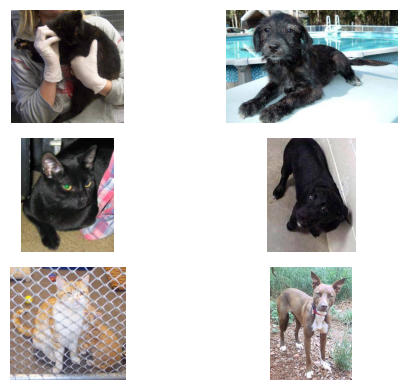

In [3]:
# Plot some of the cat and dog images
fig, axs=plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

fig.tight_layout()

## 2. EDA

Let's take a deeper look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

In [4]:
# Load one of the dogs
dog=image.load_img(training_dogs[0])

# And convert it to an array - this is how TensorFlow will handel the data
dog=image.img_to_array(dog)

# Take a look at some properties of the object
print(f'Image data is: {type(dog)}')
print(f'Image data shape: {dog.shape}')

Image data is: <class 'numpy.ndarray'>
Image data shape: (331, 500, 3)


The data has shape of 375 x 499 x 3? The image is 375 x 499 pixels, that makes sense. But what is the 3? Let's plot the pixel values and you will see what is going on:

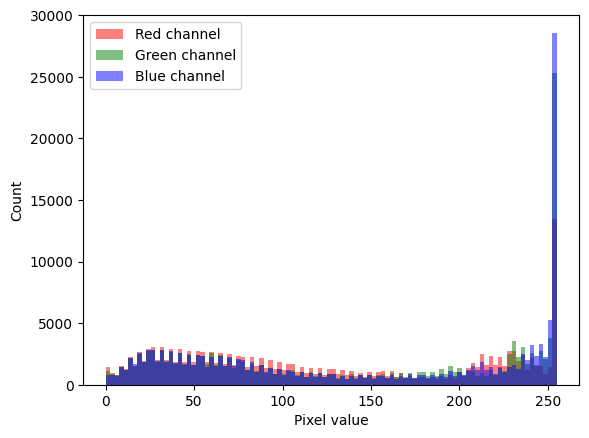

In [5]:
plt.hist(dog[:,:,0].flatten(), bins=100, color='red', alpha=0.5, label='Red channel')
plt.hist(dog[:,:,1].flatten(), bins=100, color='green', alpha=0.5, label='Green channel')
plt.hist(dog[:,:,2].flatten(), bins=100, color='blue', alpha=0.5, label='Blue channel')
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

There are a few interesting observations we can make here:

1. This array has 3 axes: 375 x 499 x 3. The first two are the dimensions of the image, the third is the three color channels: red, green and blue.
2. 375 x 499 x 3 is over a half million individual values - this one image is 10 time more data that any of the other datasets we have worked with so far!
3. The range of pixel values is from 0 to about 250 - in reality it is (0,255) for a total range of 256 possible values per pixel. This is defined by the JPEG image standard.

There are two things we can do with this information. First, we should scale the pixel values, this will improve the training of our neural network. We can do this directly in the model definition by adding a normalization layer. Second, we can make the images gray scale, which will decrease the input size and therefore computational burden by a factor of three. We can do this via the image dataset generator.

### 2.2. Image dimensions

Let's take a look at a random sample of images from the dataset and see what their dimensions are.

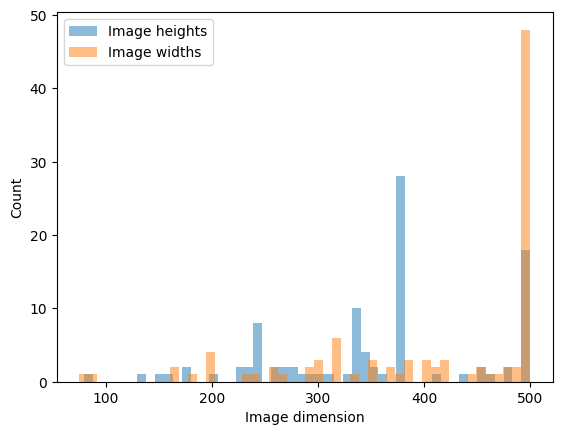

In [6]:
# Get a random sample of images, half cats and half dogs
sample_size=100
sample=random.sample(training_dogs, sample_size//2)
sample+=random.sample(training_cats, sample_size//2)

# Collectors for data
heights=[]
widths=[]

# Loop on the sample images
for sample_image in sample:

    # Load the image and convert it to an array
    sample_image=image.load_img(sample_image)
    sample_image=image.img_to_array(sample_image)

    # Get the width and height and add to collections
    heights.append(sample_image.shape[0])
    widths.append(sample_image.shape[1])

# Plot results as a histogram
plt.hist(heights, bins=50, alpha=0.5, label='Image heights')
plt.hist(widths, bins=50, alpha=0.5, label='Image widths')
plt.xlabel('Image dimension')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

Based on the above plot, let's set our image dimension at 64 or 128 pixels. Smaller is better for training speed and memory use, but we don't want to go too small, then the model will have a hard time learning from the data. There is no hard and fast rule here. You could do an experiment testing several different image dimensions to see how small we could make the image and still get good performance.

### 2.3. Image aspect ratios

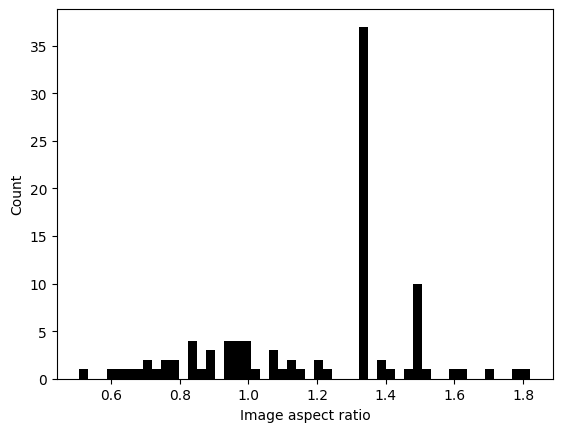

In [7]:
# Calculate the sample image aspect ratios
aspect_ratios=np.array(widths)/np.array(heights)

# Plot as histogram
plt.hist(aspect_ratios, bins=50, color='black')
plt.xlabel('Image aspect ratio')
plt.ylabel('Count')
plt.show()

The most common aspect ratio in the data set looks to be around 1.3 - which is the '4:3' aspect ratio that used to be the standard for computer monitors. Rather than using square input images, we can use this aspect ratio to better match the data.

## 3. Model

Now it's time to build and train the model. We will do this in a few steps, evaluating performance by looking at the training curves along the way:

1. Establish baseline performance with default settings
2. Optimize the batch size and learning rate
3. Optimize regularization with L1 and L2 penalties
4. Optimize input image size for speed and/or better performance
5. Optimize network architecture
6. Final model and evaluation

### 3.1. Baseline model performance

Training run already complete, loading results from disk.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 64, 48, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 46, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 23, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 21, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 10, 32)       0         
 2D)                                                            

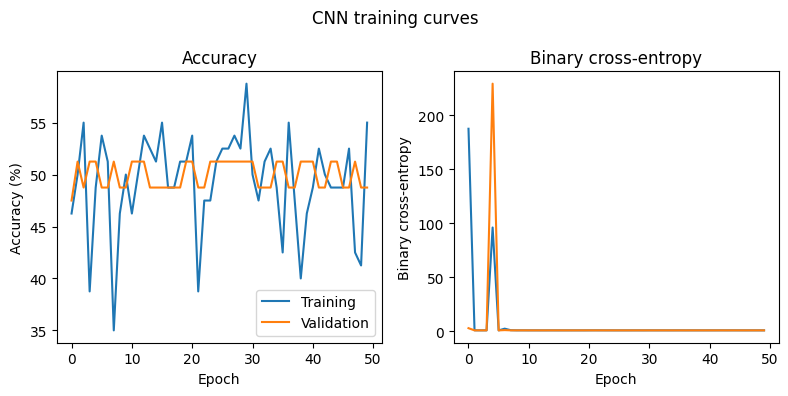


CPU times: user 13.7 s, sys: 24.1 s, total: 37.8 s
Wall time: 1min 4s


In [8]:
%%time

# Do a single training run with default settings
training_results=single_training_run(
    training_data_path,
    image_width=64,
    aspect_ratio=4/3,
    epochs=50
)

training_results.model.summary()

# Plot the results
plot_single_training_run(training_results).show()

print()

OK, not great. Does not seem like the model is learning at all. The training curves are jumping all over the place centered around 50% accuracy - the model is just guessing. This likely indicates that the learning rate is too large and/or the batch size is too small. Let's optimize those hyperparameters first.

### 3.2. Batch size and learning rate optimization

Optimization run already complete, loading results from disk.


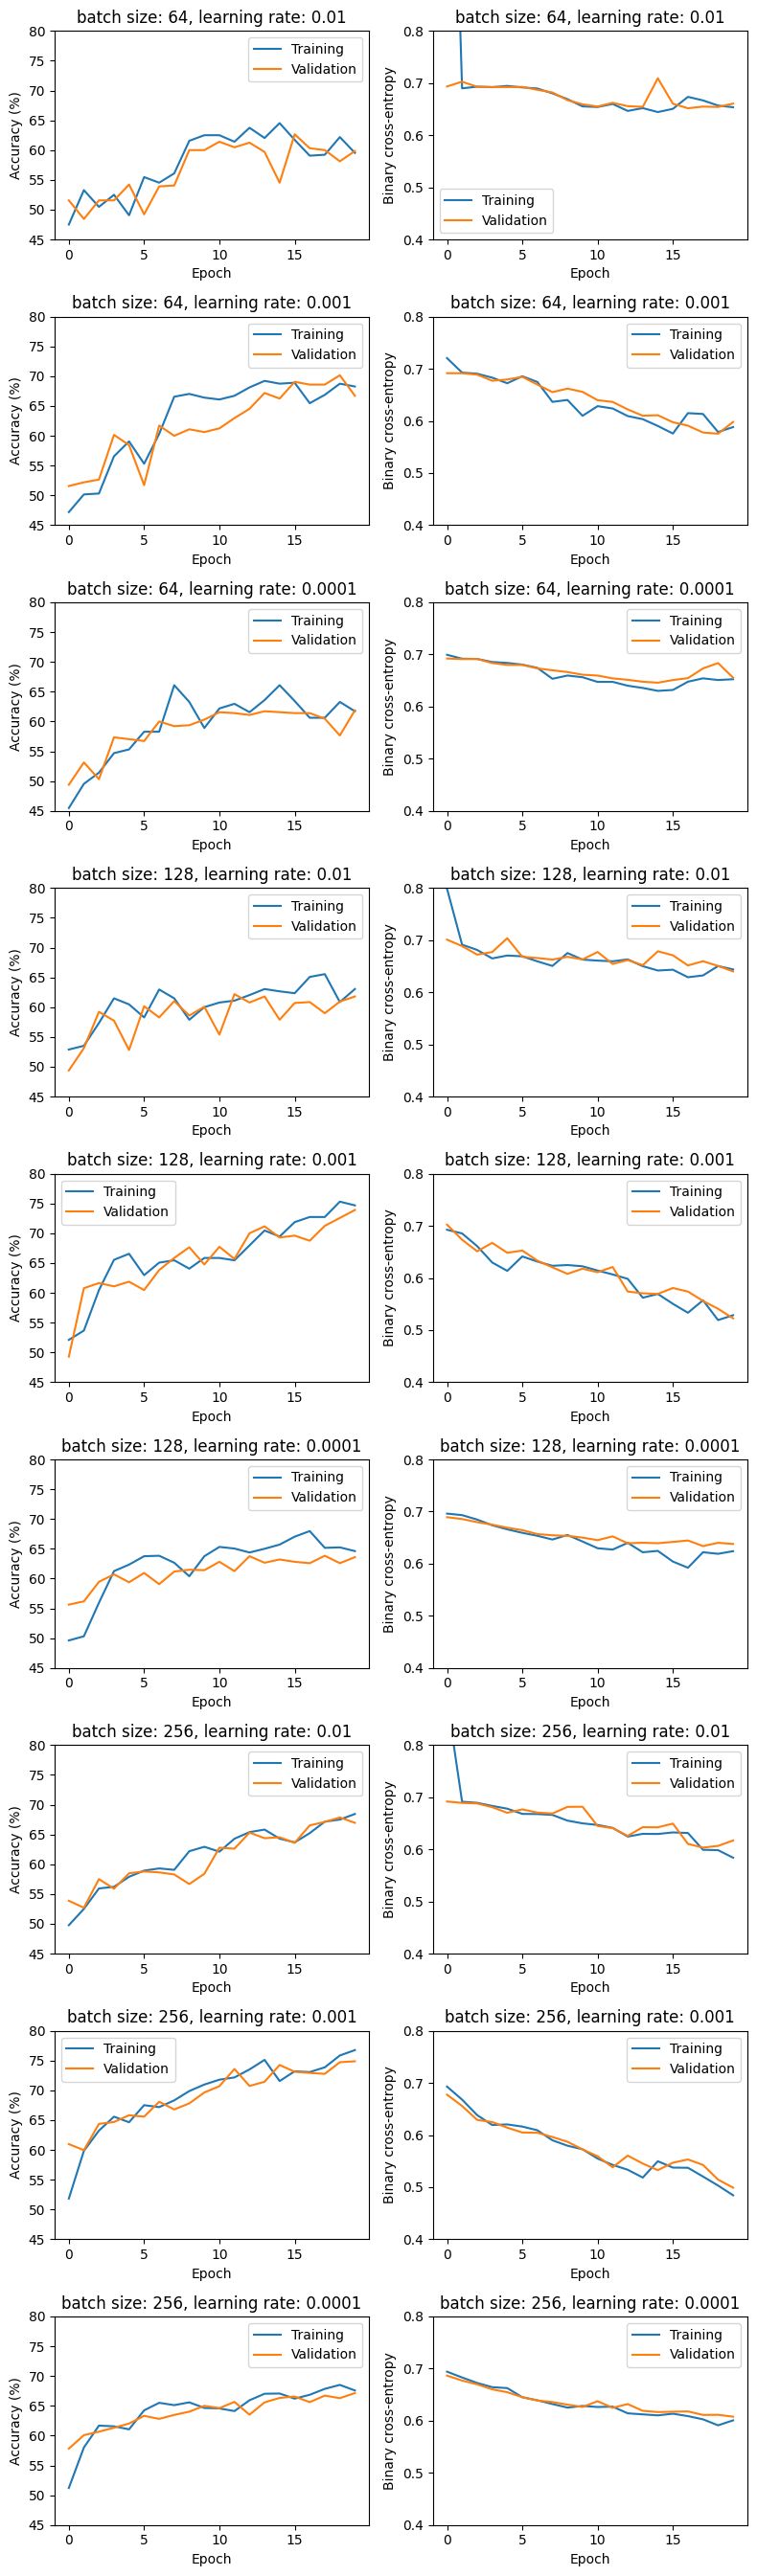


CPU times: user 7.02 s, sys: 235 ms, total: 7.26 s
Wall time: 7.07 s


In [9]:
%%time

# Define hyperparameters
hyperparameters={
    'batch_sizes': [64, 128, 256],
    'learning_rates': [0.01, 0.001, 0.0001],
    'image_widths': [64],
    'aspect_ratio': 4/3,
    'epochs': 20
}

# Train the model with each set of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['batch_sizes', 'learning_rates']

# Plot the learning curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,80],
    entropy_ylims=[0.4,0.8]
).show()

print()

From the training curves, it looks like the best results are obtained with a batch size of 256 and a learning rate of 0.001. That conclusion is somewhat subjective and based on how close the training and validation score curves are to each other, their smoothness and the final performance achieved at the end of the test run. We also need to consider computational resources. Continued experiments with a batch size to 256 will take longer than with a batch size of 128. The best philosophy after a first experiment is to take the smallest/fastest result that is acceptable and use it for continued testing.

Let's use the best batch size and learning rate settings and train the model for longer to see how it does.

Training run already complete, loading results from disk.


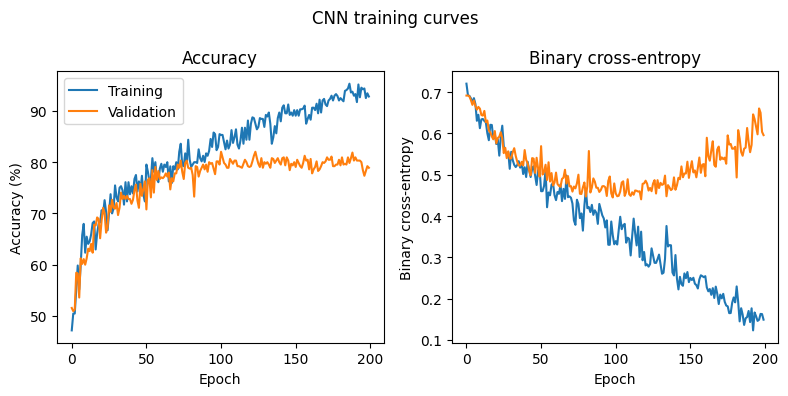


CPU times: user 2.63 s, sys: 1.24 s, total: 3.87 s
Wall time: 6.06 s


In [10]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'image_width': 64,
    'aspect_ratio': 4/3,
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 200
}

# Do a single training run
training_results=single_training_run(training_data_path, **hyperparameters)

# Plot the results
plot_single_training_run(training_results).show()

print()

Good! Much better. But we are clearly over fitting - let's add some regularization.

### 3.3. Regularization

Optimize L1 and L2 penalties using the optimized batch size and learning rate from the previous experiment.

Optimization run already complete, loading results from disk.


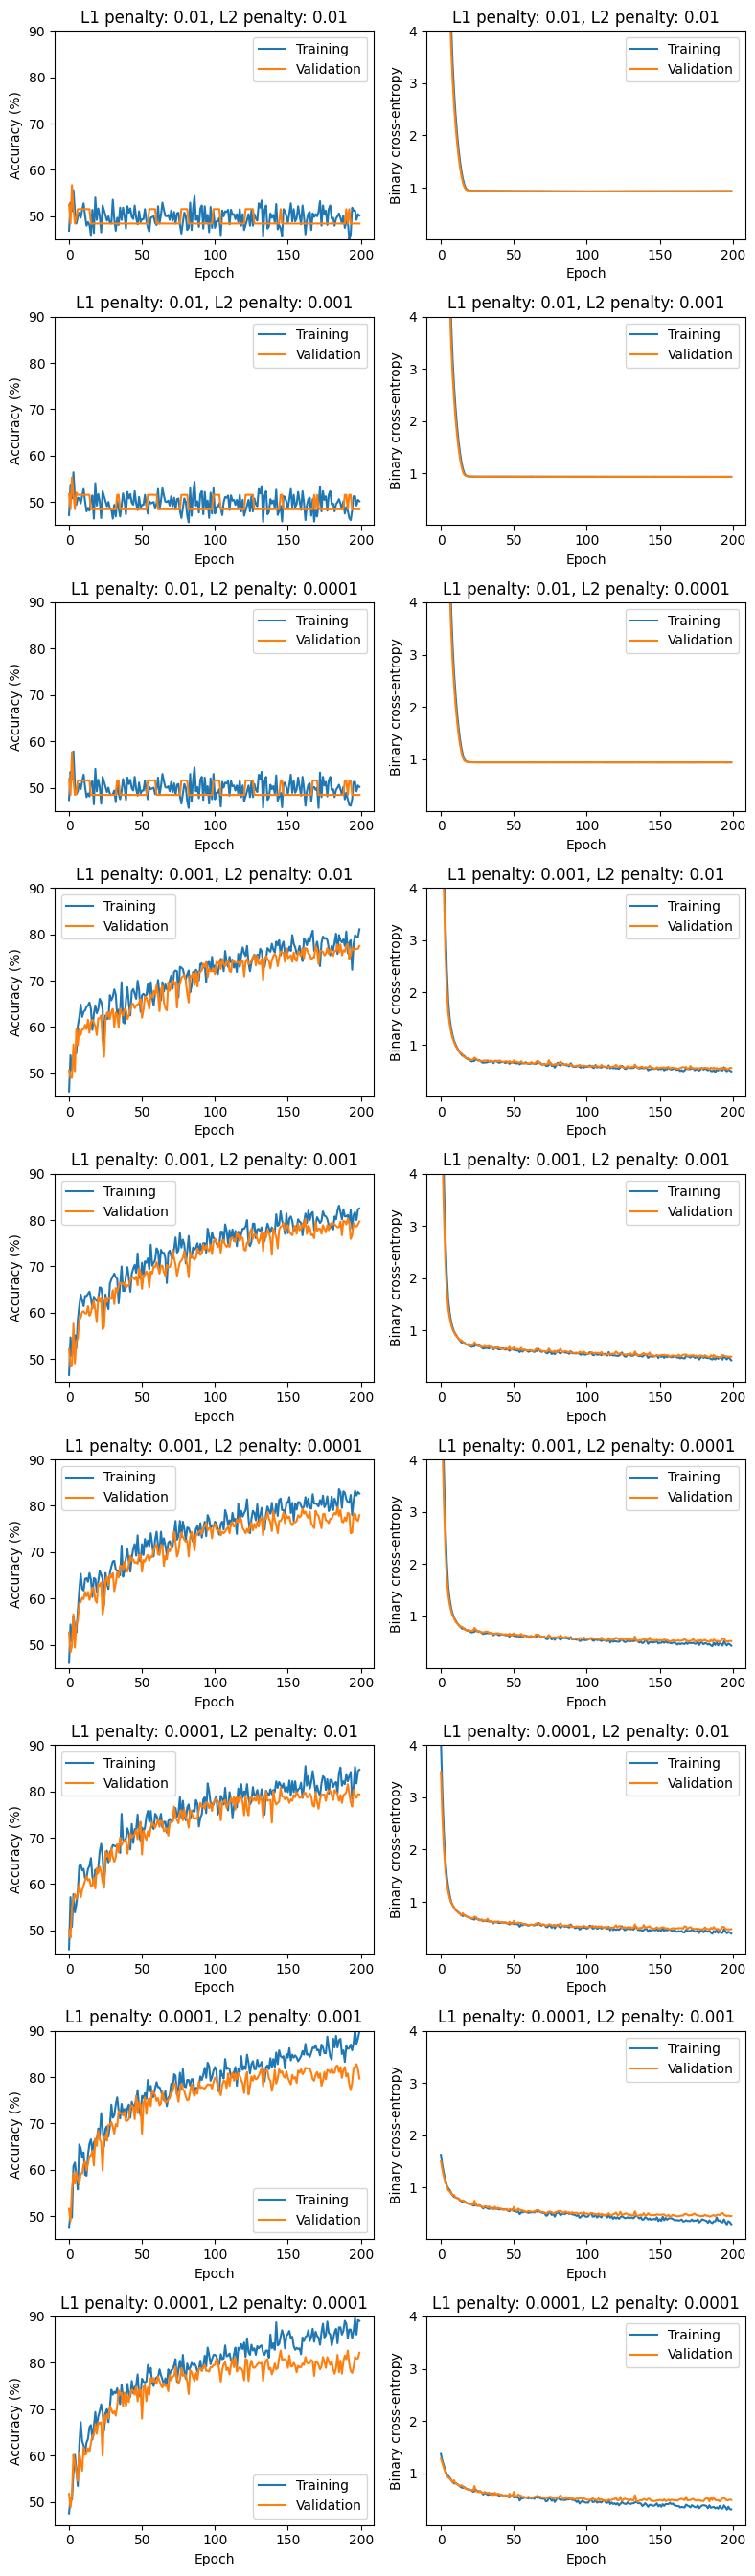


CPU times: user 6.67 s, sys: 319 ms, total: 6.99 s
Wall time: 6.8 s


In [11]:
%%time

# Define hyperparameters
hyperparameters={
    'l1_penalties': [0.01, 0.001, 0.0001],
    'l2_penalties': [0.01, 0.001, 0.0001],
    'batch_sizes': [64],
    'learning_rates': [0.001],
    'image_widths': [64],
    'aspect_ratio': 4/3,
    'epochs': 200
}

# Train the model with each set of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['l1_penalties', 'l2_penalties']

# Plot the learning curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,90],
    entropy_ylims=[0.01,4.0]
).show()

print()

Training run already complete, loading results from disk.


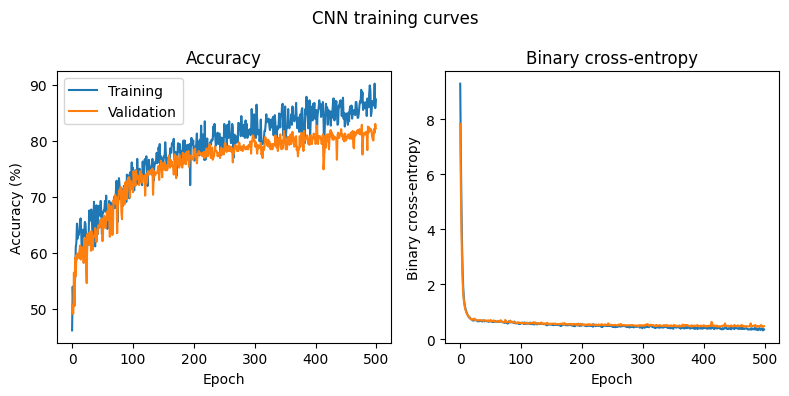


CPU times: user 2.43 s, sys: 1.42 s, total: 3.85 s
Wall time: 5.64 s


In [12]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'l1_penalty': 0.001,
    'l2_penalty': 0.01,
    'image_width': 64,
    'aspect_ratio': 4/3,
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 500
}

# Do a single training run
training_results=single_training_run(training_data_path, **hyperparameters)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 3.4. Input image size optimization

Try some smaller input image sizes and see how the model does with the hyperparameter settings we have chosen via optimization so far.

Optimization run already complete, loading results from disk.


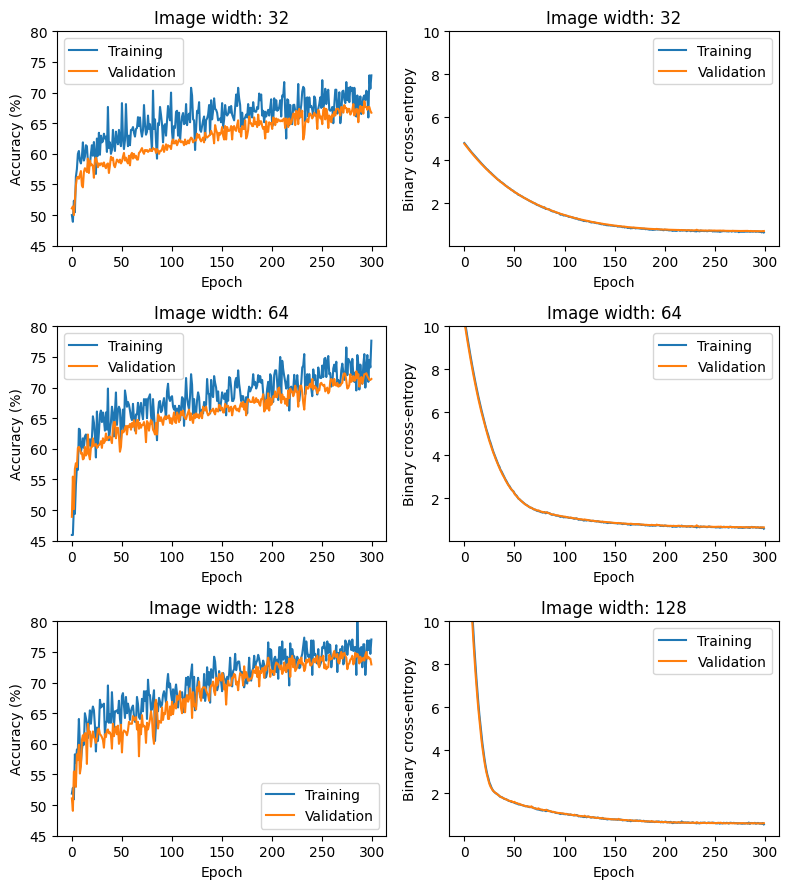


CPU times: user 2.63 s, sys: 268 ms, total: 2.9 s
Wall time: 2.54 s


In [13]:
%%time

# Define hyperparameters
hyperparameters={
    'l1_penalties': [0.001],
    'l2_penalties': [0.01],
    'batch_sizes': [64],
    'learning_rates': [0.0001],
    'image_widths': [32, 64, 128],
    'aspect_ratio': 4/3,
    'epochs': 300
}

# Train the model with each combination of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['image_widths']

# Plot the training curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,80],
    entropy_ylims=[0.01,10.0]
).show()

print()

Training run already complete, loading results from disk.


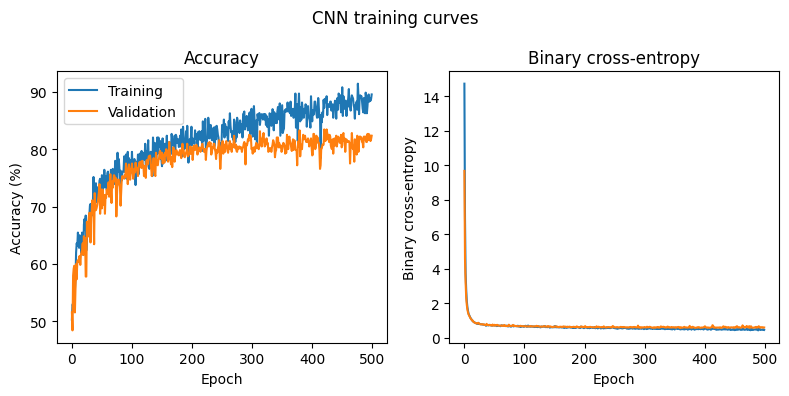


CPU times: user 2.28 s, sys: 589 ms, total: 2.87 s
Wall time: 2.13 s


In [14]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'l1_penalty': 0.001,
    'l2_penalty': 0.01,
    'image_width': 128,
    'aspect_ratio': 4/3,
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 500
}

# Do a single training run
training_results=single_training_run(training_data_path, **hyperparameters)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 3.5. Model architecture

#### 3.5.1. Convolutional layers

Optimization run already complete, loading results from disk.


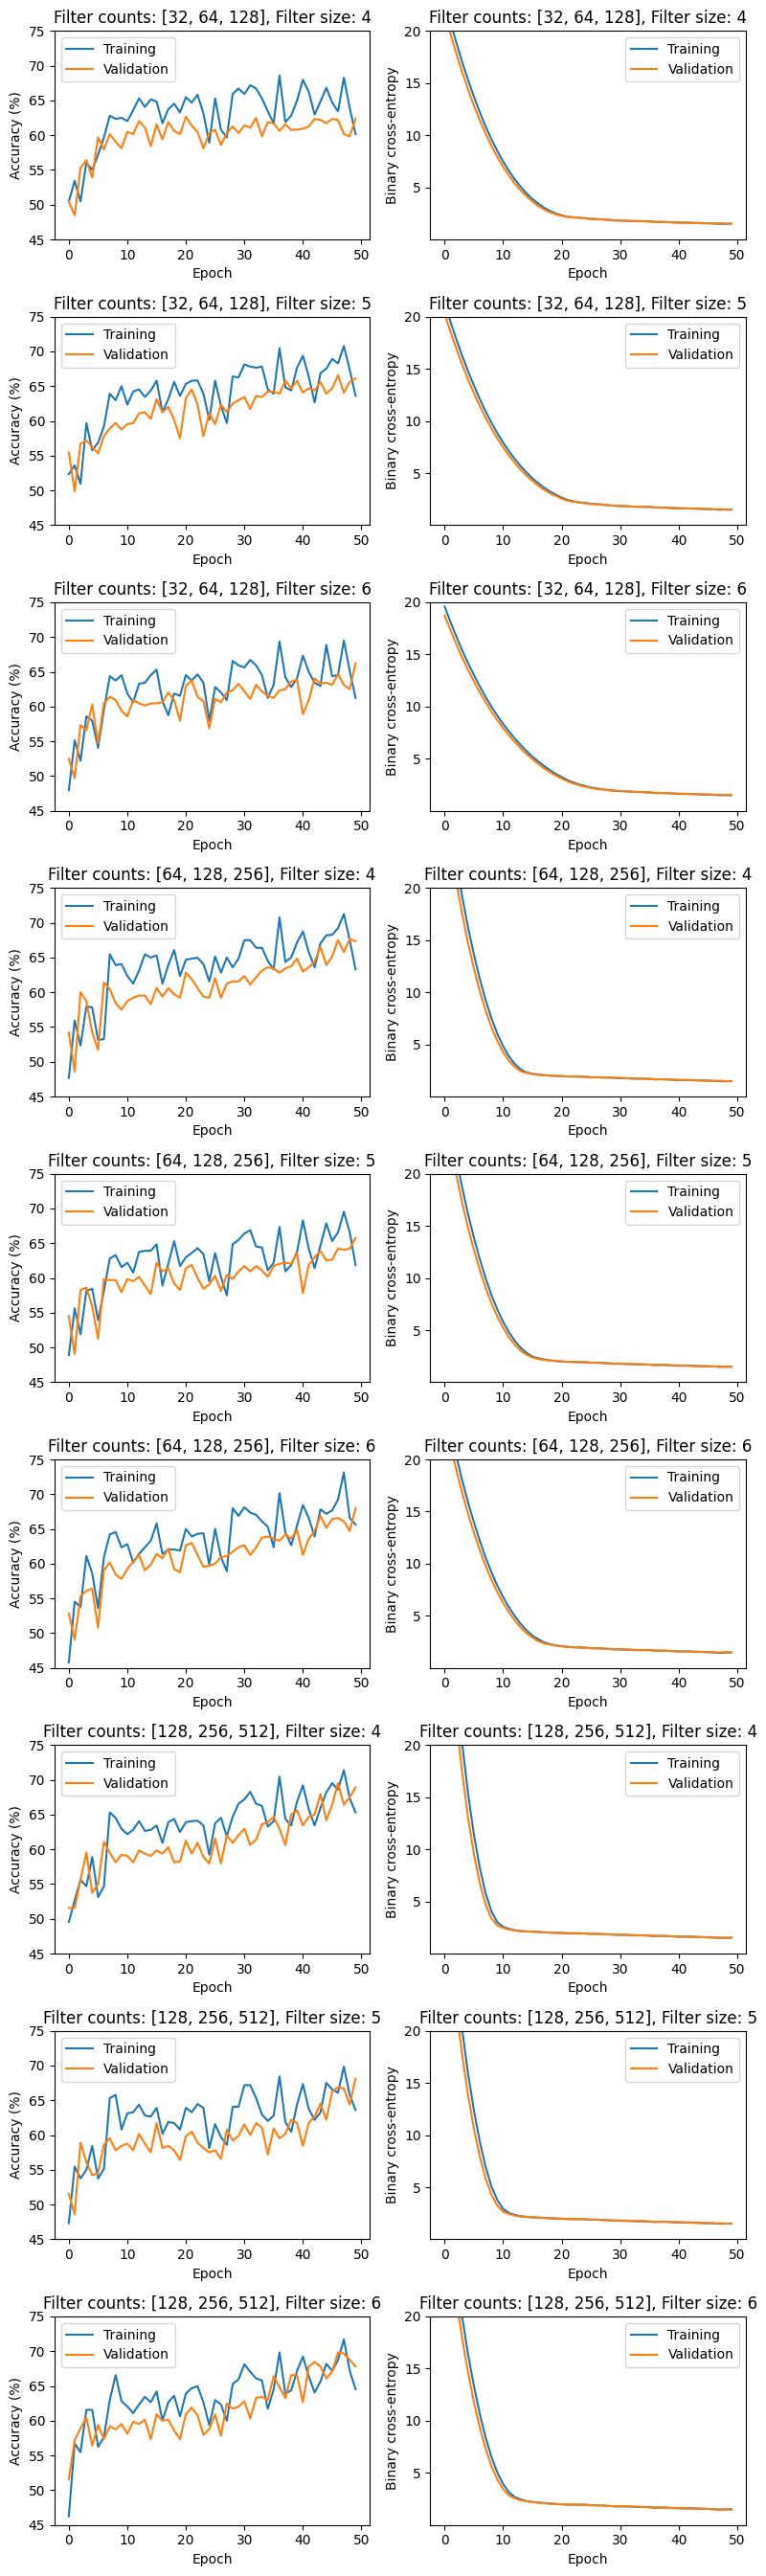


CPU times: user 7.96 s, sys: 1.82 s, total: 9.78 s
Wall time: 9.66 s


In [15]:
%%time

# Define hyperparameters
hyperparameters={
    'filter_nums_list': [[32,64,128],[64,128,256],[128,256,512]],
    'filter_sizes': [4,5,6],
    'l1_penalties': [0.001],
    'l2_penalties': [0.01],
    'batch_sizes': [64],
    'learning_rates': [0.0001],
    'image_widths': [128],
    'aspect_ratio': 4/3,
    'epochs': 50
}

# Train the model with each combination of hyperparameters
hyperparameter_optimization_results=hyperparameter_optimization_run(
    training_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['filter_nums_list', 'filter_sizes']

# Plot the training curves
plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels,
    accuracy_ylims=[45,75],
    entropy_ylims=[0.01,20.0]
).show()

print()

Training run already complete, loading results from disk.


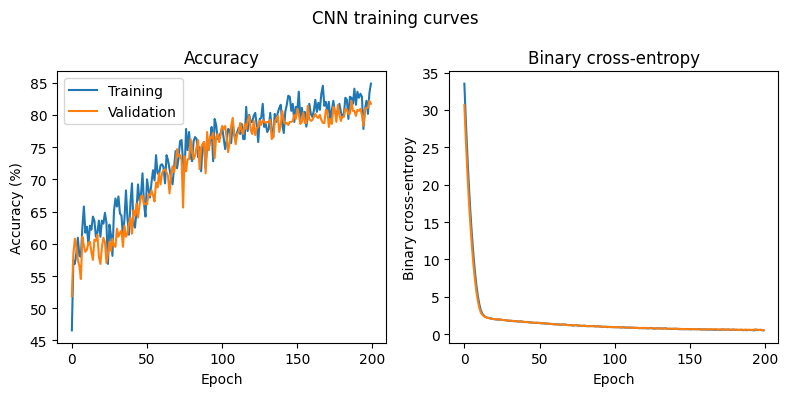


CPU times: user 3.02 s, sys: 1.6 s, total: 4.62 s
Wall time: 5.92 s


In [16]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'filter_nums': [128,256,512],
    'filter_size': 6,
    'l1_penalty': 0.001,
    'l2_penalty': 0.01,
    'image_width': 128,
    'aspect_ratio': 4/3,
    'batch_size': 64,
    'learning_rate': 0.0001,
    'epochs': 200
}

# Do a single training run
training_results=single_training_run(training_data_path, **hyperparameters)

# Plot the results
plot_single_training_run(training_results).show()

print()

## 4. Model performance

### 4.1. Train model with final parameters

Training run already complete, loading results from disk.


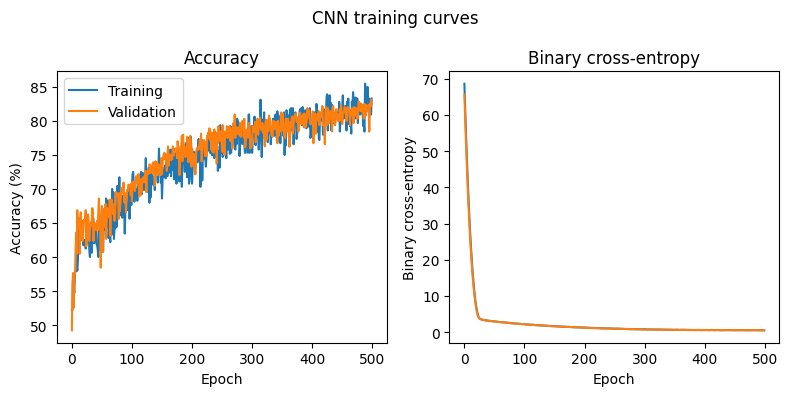


CPU times: user 2.33 s, sys: 1.05 s, total: 3.37 s
Wall time: 2.88 s


In [17]:
%%time

# Set some hyperparameters for the run
hyperparameters={
    'filter_nums': [128,256,512],
    'filter_size': 6,
    'l1_penalty': 0.002,
    'l2_penalty': 0.02,
    'image_width': 128,
    'aspect_ratio': 4/3,
    'batch_size': 64,
    'learning_rate': 0.00005,
    'epochs': 500,
    'return_datasets': True
}

# Do a single training run
training_results, training_dataset, validation_dataset=single_training_run(
    training_data_path,
    **hyperparameters
)

# Plot the results
plot_single_training_run(training_results).show()

print()

### 4.2. Testing dataset

In [18]:
testing_dataset=tf.keras.utils.image_dataset_from_directory(
    testing_data_path,
    image_size=(128, int(128*(3/4))),
    color_mode='grayscale'
)

### 4.3. Test set performance

In [19]:
threshold=0.5
images=np.concatenate([x for x, y in validation_dataset], axis=0)
predictions=training_results.model.predict(images)
predictions=[1 if p > threshold else 0 for p in predictions]
labels=np.concatenate([y for x, y in validation_dataset], axis=0)
accuracy=accuracy_score(predictions, labels)*100

110/110 [==============================] - 9s 34ms/step


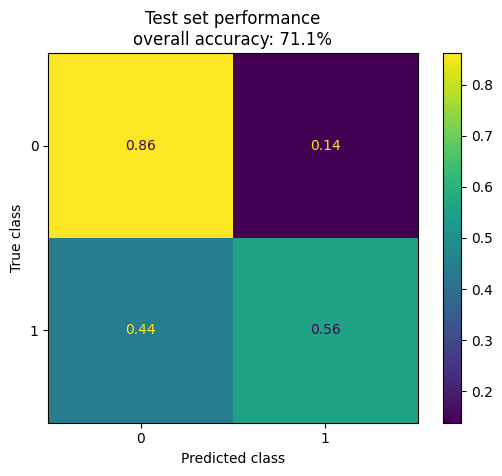

In [20]:
# Plot the confusion matrix
cm=confusion_matrix(labels, predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()